<a href="https://colab.research.google.com/github/mbednarski/sda-rnn/blob/master/Forecasting_przygotowanie_danych_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importy
Zaczymamy od zaimportowania potrzebnych bibliotek

In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

## Wczytanie danych
Na początek pobobieramy i rozpakowujemy dane.

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)


13582336/13568290 [==============================] - 0s 0us/step


Pobrany przez nas plik zawiera pomiary różnych parametrów pogodowych. Spórzmy na kilka pierwszysch wpisów aby wyrobić sobie intuicję.

In [3]:
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


Widzimy, że dane zawierają wiele parmetrów. Naszym celem będzie predykcja temperatury (T (degC)). W tym celu będziemy używać nie tylko temperatury historycznej, ale także innych zmierzonych wartości.

Dane były zbieranie z okresem 10 minut. Możemy powiedzieć że częstotliwość próbkowanania wynosi 5 razy na godzinę. W tym przypadku jest to ważne, gdyż temperatura ma charakter ciągły i pomiar odbywa się co pewien czas. W przypadku danych dyskretnych (np. sekwencja DNA, tekst) - nie mamy do czynienia z czasem pobrania próbki - po prostu mamy kolejne, następujące po sobie wartości.

Na nasze potrzeby będziemy potrzebowali danych próbkowanych co godzinę. Dlatego najpierw wybierzmy odpowiednie wiersze:


In [4]:
df = df[5::6].copy()
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


## EDA i preprocessing
Przyjrzyjmy sie rozkładowi danych:

In [5]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000
mean,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,1.702567,2.963041,174.789095
std,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,65.447512,75.597657,86.619431
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,0.990000,1.760000,125.300000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.980000,198.100000
75%,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,2.860000,4.740000,234.000000
max,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,14.010000,23.500000,360.000000


###Pytanie 1 (łatwe)
Czy widzisz jakiś problem?

Wartości wv (m/s)	max. wv (m/s)	są równe -9999 co wygląda na błąd.

### Pytanie 2 (średnie)
Czy wiesz dlaczego wiatr jest podany w dwóch kolumnach? (wd (deg) oraz wv (m/s)). Pytanie może być bardzo trudnie jeżeli nigdy nie miałeś_aś styczności z takimi danymi.

Wiatr jest podany jako azymut (kąt względem północy) oraz jego prędkość.

### Pytanie 3 (trudne)
W jaki inny sposób możemy opisać dane nt. siły i kierunku wiatru? Jaki jest problem z obecną reprezentacją?

Problem: Na przykład dla kąta waitru pomiędzy 120 a 130 stopni różnica wynosi dziesięć. A dla wiatrów 5 stopni i 355 stopni wynosi 350 - faktyczna różnica to 10 a w tej reprezentacji to aż 355. Sprawia to że wartośc cechy wd (deg) nie spełnia własności "podobne wartości powinny być reprezentowane przez podobne wielkości cech".

Rozwiązanie: wiatr można zapisać w postaci wektora - wtedy w datasecie znajdą się dwie kolumny ze współrzędną x i y

## Poprawianie outlierów. 

Wartość -9999 jest najprawdopodbniej błędna. Zamieńmy ją na zero.

### Pytanie 4 (średnie)
Dlaczego nie chcemy po prostu usunąć tych rekordów?

Odpowiedź: w ten sposób możemy zaburzyć ciągłość pomiarów. Jeżeli oryginalny dataset był próbkowany co godzinę to po usunięciu wierszy może się okazać że częstotliwośc próbkowania stała się zmienna (bo wypadły "losowe" wpisy).

In [6]:
bad_wind = df['wv (m/s)'] < 0 
bad_max_wind =  df['max. wv (m/s)'] < 0
print('Ilość rekordów z wadliwym wiatrem', bad_wind.sum())
print('Ilość rekordów z wadliwym porywem wiatru', bad_max_wind.sum())
df.loc[bad_wind, 'wv (m/s)'] = 0
df.loc[bad_max_wind, 'max. wv (m/s)'] = 0


Ilość rekordów z wadliwym wiatrem 3
Ilość rekordów z wadliwym porywem wiatru 4


Wiemy już, że azymut nie jest dobrą cechą. Najprościej będzie się jej pozbyć. Przy okazji usuńmy kolumnę ze stemplem czasowym. Nie będziemy go używać w modelu.

In [7]:
df = df.drop(columns=['wd (deg)', 'Date Time'])
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s)
5,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63
11,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63
17,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63
23,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38
29,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36
420527,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92
420533,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56
420539,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68


### Zadanie 1 (trudne)
Zaimplementuj kod który z kolumn wv (m/s) i wd (deg) utworzy dwie nowe - wind_x i wind_y. Nowe kolumny będą przechowywały wektor opisujący siłę i kierunek wiatru. Potrzebna będzie trygonometria ;)

Rozwiązanie:

Zaimplementuj równanie 
```
wind_x = wv (m/s) * sin(wd(deg))
wind_y = wv (m/s) * cos(wd(deg))
```

## Fearture engineering

### Pytanie 5 (trudne)
Pogoda zmienia się sezonowo (w zimie i w nocy jest raczej zimniej niż latem i w dzień). W jaki sposób możemy wykonać feature engineering który doda odpowiednie kolumny?

Odpowiedź: dodaj nowe kolumny na bazie pory dnia/nocy oraz pory roku. Np. dla godzin 22-6 ustaw `is_night` na True, a dla miesięcy maj-wrz `is_summer`.

Uwaga: a co z miejscami gdzie wystepuje tylko pora sucha i deszczowa? A co z pólkulą południową?

### Zadanie 2 (trudne)
Zaimplementuj odpowiedź na pytanie 5 ;)

### Zadanie 3 (bardzo trudne)
Założyliśmy w ciemno, że temperatra zmienia się w cyklu dziennym i rocznym. Sprawdź czym jest szybka transformata fouriera i wykorzystaj ją do potwierdzenia/obalenia naszej intuicji. UWAGA: zadanie wymaga dużej pracy własnej i przyswojenia konkretnej dawki wiedzy.

# Podział na zbiory treningowy/walidacyjny i testowy

Podzielmy dane na zbiory train/val/test. Zwykle podziału dokonujemy losowo, tym razem jest inaczej. Pierwsze 70% trafi do zbioru treningowego, kolejne 15% do walidacyjnego a ostatne 15% do testowego. Zapewni to bardziej wiarygodną ewaluację - model testujemy na danych późniejszych niż treningowe. Dodatkowo w ten sposób będziemy mieli zapewnioną spójność wygenerowanych okien - o co chodzi dowiesz się wkrótce ;)

In [8]:
dset_len = len(df)
df_train = df.iloc[0:int(dset_len*0.7)]
df_val = df.iloc[int(dset_len*0.7):int(dset_len*0.85)]
df_test = df.iloc[int(dset_len*0.85):]

num_features = df.shape[1]
len(df_train), len(df_val), len(df_test)

(49063, 10514, 10514)

## Normalizacja/standaryzacja

Sieć neuronowa potrzebuje danych numerycznych w standardowej postaci. Tzn, średnia każdej cechy powinna wynosić zero a jej odchylenie standardowe jeden. Dobra wiadomość jest taka, że dowolne dane możemy przekształcić do takiej formy przy użyciu wzoru:
$$ z= \frac{x-μ}{σ}$$

UWAGA, średnią i odchylenie obliczamy ze zbioru treningowego! To bardzo ważne, inaczej mamy wyciek ze zbiorów val/test.

### Pytanie 6 (trudne)
Dlaczego jest to ważne?

Odpowiedź: Jeżeli współczynniki wyliczymy też przy użyciu danych testowych to model dowiedział się częsciowo jaka jest średnia temp. i jej odchylenie w zbiorze testowy. A model nie ma prawa nic wiedzieć  o danych testowych!

In [9]:
train_mean = df_train.mean()
train_std = df_train.std()

df_train = (df_train - train_mean) / train_std
df_val = (df_val - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

In [10]:
df_train.describe().round(3)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s)
count,49063.000,49063.000,49063.000,49063.000,49063.000,49063.000,49063.000,49063.000,49063.000,49063.000,49063.000,49063.000,49063.000
mean,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-9.046,-3.682,-3.707,-4.217,-3.747,-1.610,-2.031,-0.830,-2.023,-2.032,-3.847,-1.404,-1.535
25%,-0.609,-0.707,-0.694,-0.670,-0.658,-0.751,-0.779,-0.658,-0.776,-0.776,-0.712,-0.739,-0.760
50%,0.055,0.009,0.013,0.052,0.199,-0.223,-0.156,-0.384,-0.155,-0.154,-0.078,-0.231,-0.225
75%,0.655,0.720,0.712,0.753,0.815,0.533,0.668,0.268,0.665,0.665,0.644,0.479,0.521
max,2.913,3.067,3.041,2.648,1.455,5.846,4.490,7.842,4.551,4.524,4.310,7.725,8.594


Przyjrzyjmy sie jak rozład wygląda teraz:

(W razie potrzemy omówimy funkcję `melt`)

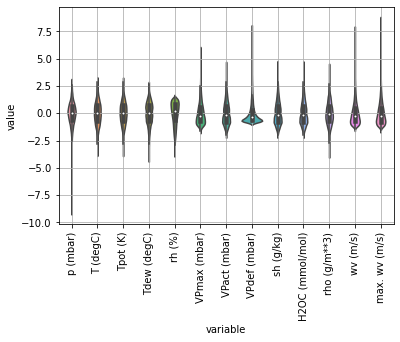

In [11]:
ax = sns.violinplot(x='variable', y='value', data=df_train.melt())
ax.grid()
_ = ax.set_xticklabels(df_train.keys(), rotation=90)

To samo dla zbioru walidacyjnego

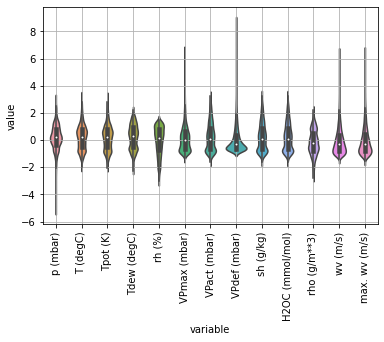

In [12]:
ax = sns.violinplot(x='variable', y='value', data=df_val.melt())
ax.grid()
_ = ax.set_xticklabels(df_val.keys(), rotation=90)

## Zapisanie zbiorów

Mamy gotowe dane, teraz wystarczy je zapisać.

Normalnie na tym korku zakończylibyśmy notebook a modelowanie zrobili w osobnym. Natomiast ze względu na wygodę prowadzenia kursu lecimy dalej ;)

In [13]:
df_train.to_csv('temperature_train.csv')
df_val.to_csv('temperature_val.csv')
df_test.to_csv('temperature_test.csv')


# Przygotowamie danych do użycia w modelu

Nadal nie wiemy jak zakodować dane tak aby użyć ich w modelu. To za chwilę się zmieni ;) 

Kod pochodzi z https://www.tensorflow.org/tutorials/structured_data/time_series Nie omawiamy go na zajęciach bo mamy ważniejsze tematy :(

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=df_train, val_df=df_val, test_df=df_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue


    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      if len(predictions.shape) == 2:
        predictions = tf.expand_dims(predictions,1)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Ważniejsze jest w jaki sposób możemy go użyć. Ofc, takie generowanie okienek można sobie napisać samemu!

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12]
Label column name(s): ['T (degC)']


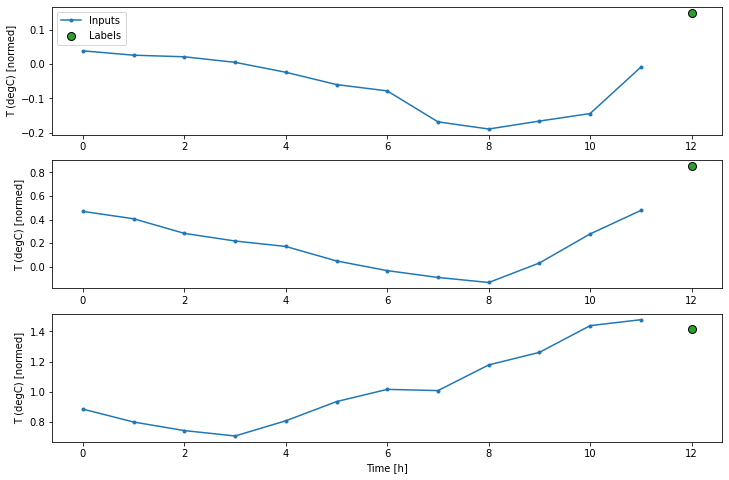

In [19]:
next_in_12_h = WindowGenerator(input_width=12, label_width=1, shift=1, label_columns=['T (degC)'])
print(next_in_12_h)
next_in_12_h.plot()

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']


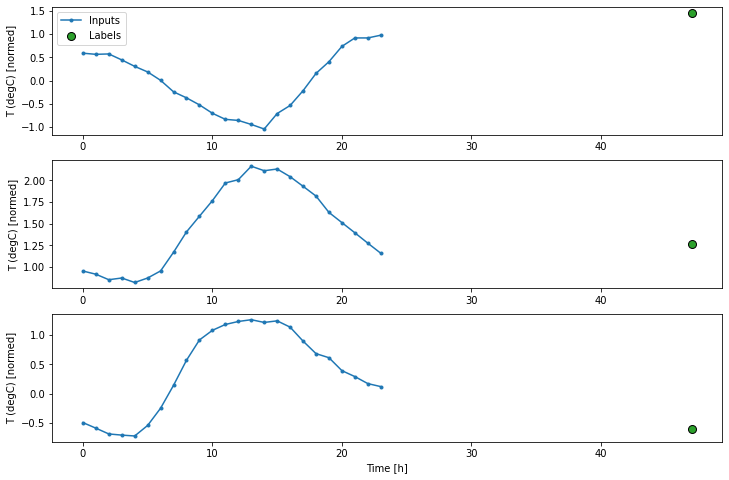

In [20]:
lookahead_24h = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'])
print(lookahead_24h)
lookahead_24h.plot()

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): ['T (degC)']


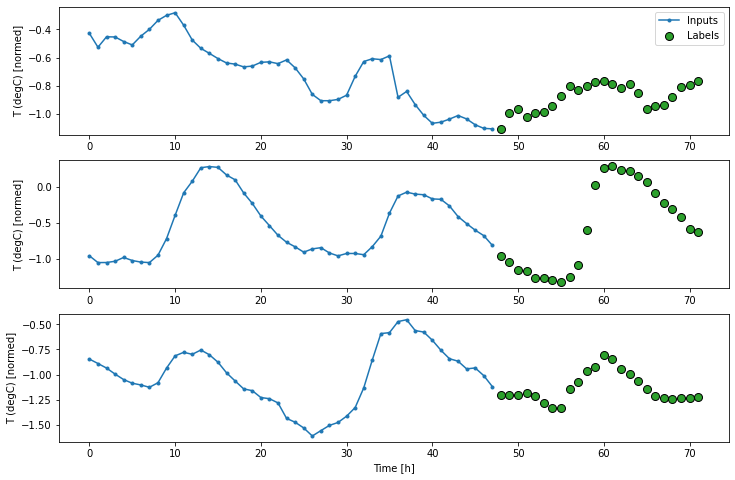

In [21]:
continous_24h = WindowGenerator(input_width=48, label_width=24, shift=24, label_columns=['T (degC)'])
print(continous_24h)
continous_24h.plot()

## Pytanie 7 (średnie/trudne)

Jaki baseline możemy wymyślić?

Odpowiedź (przykładowa):
* ostatnia wartość
* średnia wartość z tego samego dnia i godziny w historii


### Pytanie 8 (trudne)

Czy istnieje górna granica skuteczności modelu której nie możemy przekroczyć?

Odpowiedź: Tak, np. nie możemy oczekiwać dokładności wyższej niż precyzja termometru

# Modelowanie

In [28]:
from tensorflow import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

### Pytanie 9 (łatwe)

Jakiej metryki użyjemy do przewidywania temperatury?

Odpowiedź: mae lub mse - to zależy na czym nam zależy.


$ \text{mse} = (y - \hat{y})^2 $


$ \text{mae} = |y - \hat{y}| $


Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12]
Label column name(s): ['T (degC)']


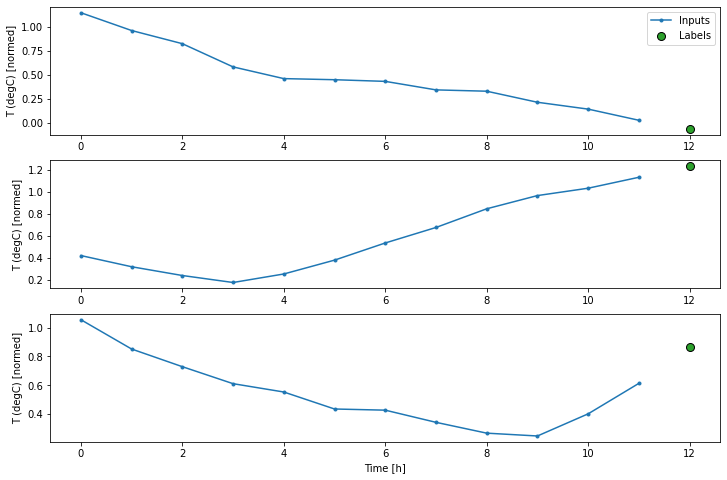

In [25]:
next_in_12_h = WindowGenerator(input_width=12, label_width=1, shift=1, label_columns=['T (degC)'])
print(next_in_12_h)
next_in_12_h.plot()

In [37]:
rnn_model = keras.models.Sequential()
rnn_model.add(layers.SimpleRNN(32))
rnn_model.add(layers.Dense(1))

criterion = MeanSquaredError()
optim = Adam()

rnn_model.compile(optimizer=optim, loss=criterion, metrics=['mae', 'mse'])

history = rnn_model.fit(next_in_12_h.train, epochs=7, validation_data=next_in_12_h.val)
rnn_model.summary()

Epoch 1/7
1533/1533 [==============================] - 22s 14ms/step - loss: 0.0209 - mae: 0.0928 - mse: 0.0209 - val_loss: 0.0093 - val_mae: 0.0674 - val_mse: 0.0093
Epoch 2/7
1533/1533 [==============================] - 22s 14ms/step - loss: 0.0091 - mae: 0.0675 - mse: 0.0091 - val_loss: 0.0096 - val_mae: 0.0697 - val_mse: 0.0096
Epoch 3/7
1533/1533 [==============================] - 23s 15ms/step - loss: 0.0085 - mae: 0.0652 - mse: 0.0085 - val_loss: 0.0084 - val_mae: 0.0627 - val_mse: 0.0084
Epoch 4/7
1533/1533 [==============================] - 24s 16ms/step - loss: 0.0082 - mae: 0.0638 - mse: 0.0082 - val_loss: 0.0081 - val_mae: 0.0630 - val_mse: 0.0081
Epoch 5/7
1533/1533 [==============================] - 22s 14ms/step - loss: 0.0081 - mae: 0.0633 - mse: 0.0081 - val_loss: 0.0082 - val_mae: 0.0619 - val_mse: 0.0082
Epoch 6/7
1533/1533 [==============================] - 23s 15ms/step - loss: 0.0078 - mae: 0.0622 - mse: 0.0078 - val_loss: 0.0078 - val_mae: 0.0602 - val_mse: 0.007

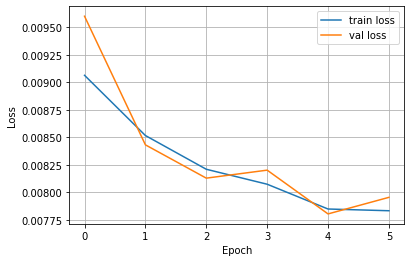

In [39]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss[1:], label='train loss')
plt.plot(val_loss[1:], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

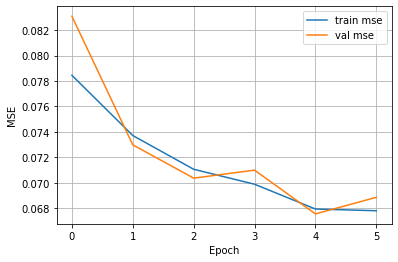

In [44]:
train_real_mse = np.array(history.history['loss']) * train_std[1]
val_real_mse = np.array(history.history['val_loss']) * train_std[1]

plt.plot(train_real_mse[1:], label='train mse')
plt.plot(val_real_mse[1:], label='val mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()

In [29]:
class TemperatureModel(keras.Model): # definiujemy model przez subclassing
  def __init__(self, rnn_hidden_size): # hidden size przekazujemy jako parametr modelu
    # ofc równie dobrze możemy zahardcodować (i tak generalnie robimy w trakcie kursu)
    # żeby oszczędzić trochę czasu na pisaniu 
    super().__init__(self)

    self.fc = layers.Dense(1) # jeden neuron na wyjściu (przewidujemy jedną wartość).
    self.rnn = layers.SimpleRNN(rnn_hidden_size) # prosta sieć rnn
    # bez aktywacji ponieważ robimy regresję!

  def call(self, inputs, training=False):
    x = inputs
    x = self.rnn(x, training=training)
    x = self.fc(x, training=training)

    return x


tm = TemperatureModel(32) # model rnn o wielkości 32
# tm.build(input_shape=[None, 12, 13]) # input batch size x szerokość okna wejściowego (czly seq len - to to samo) x 13 features]
# tm.summary()

criterion = MeanSquaredError() # MSE
optim = Adam()

tm.compile(optimizer=optim, loss=criterion, metrics=['mae', 'mse']) # do raportowania spojrzymy też na mae

history = tm.fit(next_in_12_h.train, epochs=3, validation_data=next_in_12_h.val)

Epoch 1/3
1533/1533 [==============================] - 28s 16ms/step - loss: 0.0175 - mae: 0.0874 - mse: 0.0175 - val_loss: 0.0103 - val_mae: 0.0707 - val_mse: 0.0103
Epoch 2/3
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0093 - mae: 0.0685 - mse: 0.0093 - val_loss: 0.0094 - val_mae: 0.0675 - val_mse: 0.0094
Epoch 3/3
1533/1533 [==============================] - 21s 14ms/step - loss: 0.0089 - mae: 0.0668 - mse: 0.0089 - val_loss: 0.0092 - val_mae: 0.0670 - val_mse: 0.0092


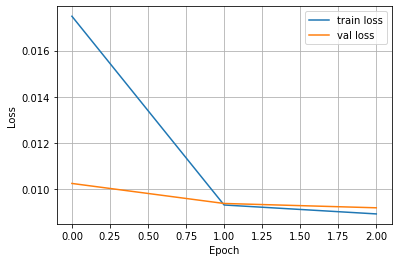

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()